
***Assignment 4***
------------------

***Submitted by Rahul Raju Pattar***


*Draw a curve for DV01 risk of a puttable bond, which is due to mature at 30 years and have a feature of put at 15 years. Where will the maximum exposure be? Shall this bond be sold at premium or discount compared to a bond without optionability. Write the DV01 function in python and take the interest rate curve for LIBOR.*


***Discussion***

***DV01 (Dollar Value of 01)***: DV01 measures the change in the price of a bond for a 1 basis point (0.01%) change in interest rates. 

***Putable Bond:***

**1.** A putable bond is a stright/normal bond with an embedded put option.\
**2.** A put option gives the bondholder the right to put back the bond at par to the issuer before expiration.\
**3.** The relationship between the values of a putable bond, the underlying option free (straight) bond, and the embedded option is given by
$$
V_{\text{Putable bond}} = V_{\text{Straight bond}} + V_{\text{Put}}
$$
**4.** **A puttable bond is typically sold at a premium compared to a non-optionable bond** due to the added value of the put option for the bondholder.

***Puttable Bond Features:***(As given in the assignment)

- Maturity: 30 years.
- Put Option: The bondholder can put (sell) the bond back to the issuer after 15 years.

***Maximum Exposure:***

- For a puttable bond, the DV01 will generally be lower than that of a non-puttable bond because the put option provides a floor on the bond's price. The maximum exposure (highest DV01) will likely be before the put date, as the bondholder has the option to sell the bond back at par if interest rates rise.

- When interest rates rise significantly, the value of the bond will decrease. In such a scenario, the bondholder might choose to put the bond back to the issuer and reinvest the proceeds at higher prevailing interest rates.


***Procedure to calculate DV01 of a putable bond***

**Step 1.** **Interest Rates:** We get the real time treasury yields for different maturities from yahoo finance database. Plot the YTM curve by interpolating the obtained yields.  \
**Step 2.** **Staright Bond:** Calculate the bond price for straight bond for various yields.\
**Step 3.** **Putable Bond and DV01 values:** Calculate the bond price for putable bond and DV01 values for both straight and putable bonds for various yields.\
**Step 4.** Plot the curves for the two bonds and their DV01 values.\
**Step 5.** Analyse the curves for the maximum exposures by comparing the two bonds.

***References***

- IIQF-CPQFRM class notes

- Website: https://analystprep.com/study-notes/cfa-level-2/compare-effective-durations-of-callable-putable-and-straight-bonds/

In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d;

**Bond Parameters**
-------------------

In [2]:
# Bond parameters
face_value = 100
coupon_rate = 0.04
maturity = 30
put_option_year = 15
n = 2  # Number of payments per year

***STEP 1***
-------------

In [3]:
#Getting real time treasury yield rates

def get_interest_rates():
    # This is a simplified approach. In practice, you'd use a proper financial data provider
    tickers = ["^IRX", "^FVX", "^TNX", "^TYX"]  # 13-week, 5-year, 10-year, 30-year
    maturities = [0.25, 5, 10, 30]
    
    rates = []
    for ticker in tickers:
        try:
            data = yf.Ticker(ticker).history(period="1d")
            rates.append(data['Close'].iloc[-1] / 100)  # Convert percentage to decimal
        except:
            rates.append(None)
    
    # Remove any None values
    valid_rates = [(mat, rate) for mat, rate in zip(maturities, rates) if rate is not None]
    return valid_rates

In [4]:
# Making a list of Maturities and corresponding Interest Rates

maturities = [i[0] for i in get_interest_rates()]
interest_rates = [i[1].round(4) for i in get_interest_rates()]

#Interpolating Interest rates against maturities
interest_rate_curve = interp1d(maturities, interest_rates, kind='linear')

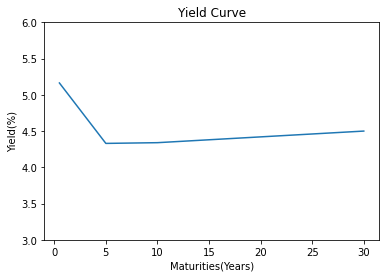

In [5]:
# Maturity time range for analysis
time_for_rate_range = np.linspace(0.5, 30, 60)

#Plotting YTM Curve
plt.ylim(3, 6)
plt.plot(time_for_rate_range, interest_rate_curve(time_for_rate_range)*100);
plt.title('Yield Curve')
plt.ylabel('Yield(%)')
plt.xlabel('Maturities(Years)');

**STEP 2**
----

In [6]:
# Function to calculate bond price
def bond_price(face_value, coupon_rate, maturity, yield_rate,n):
    periods = maturity * n
    coupon = coupon_rate * face_value / n
    discount_factors = [(1 + yield_rate / n) ** -(i + 1) for i in range(periods)]
    price = sum([coupon * discount_factors[i] for i in range(periods)]) + face_value * discount_factors[-1]
    return price

In [7]:
#Calulate the staright bond prices for given yields
yield_rates = np.linspace(2,7,100)
bond_prices = [bond_price(face_value, coupon_rate, maturity, yield_rate,n) for yield_rate in yield_rates/100]

***STEP 3***
-------------

In [8]:
# Function to calculate DV01 of Straight Bond
def DV01_Straight_Bond(face_value, coupon_rate, maturity, yield_rate, n):
    price_up = bond_price(face_value, coupon_rate, maturity, yield_rate + 0.0001, n)
    price_down = bond_price(face_value, coupon_rate, maturity, yield_rate - 0.0001, n)
    dv01_value = (price_down - price_up) / 2
    return dv01_value

# Function to calculate DV01 of Putable Bond
def DV01_Putable_Bond(face_value, coupon_rate, maturity, yield_rate, n):    
    put_price_up = bond_price(face_value, coupon_rate, put_option_year, yield_rate + 0.0001, n)
    put_price_down = bond_price(face_value, coupon_rate, put_option_year, yield_rate - 0.0001, n)
    
    final_price_up = max(bond_price(face_value, coupon_rate, maturity, yield_rate + 0.0001, n), put_price_up)
    final_price_down = max(bond_price(face_value, coupon_rate, maturity, yield_rate - 0.0001, n), put_price_down)
    DV01_value_Putable_Bond = (final_price_down - final_price_up) / 2
    
    return DV01_value_Putable_Bond

In [9]:
# Calculate Putable bond price and DV01 values for different yields

Putable_bond_prices=[]
DV01_values_Straight_Bond = []
DV01_values_Putable_Bond = []
put_prices = []

for rate in yield_rates/100:
    if maturity > put_option_year:
        put_price = bond_price(face_value, coupon_rate, put_option_year, rate, n)
        final_price = max(bond_price(face_value, coupon_rate, maturity, rate, n), put_price)
        put_prices.append(put_price)
    else:
        final_price = bond_price(face_value, coupon_rate, maturity, rate, n)
    Putable_bond_prices.append(final_price)
    DV01_values_Straight_Bond.append(DV01_Straight_Bond(face_value, coupon_rate, maturity, rate, n))
    DV01_values_Putable_Bond.append(DV01_Putable_Bond(face_value, coupon_rate, maturity, rate, n))

***STEP 4***
-------------

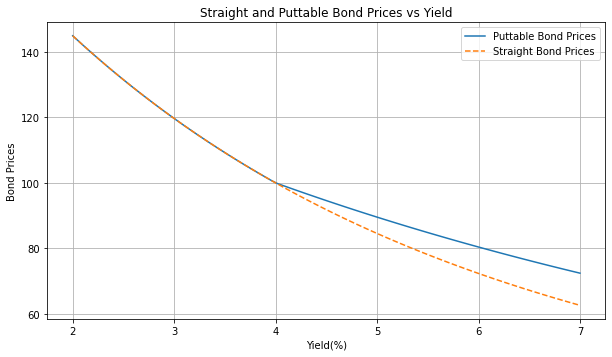

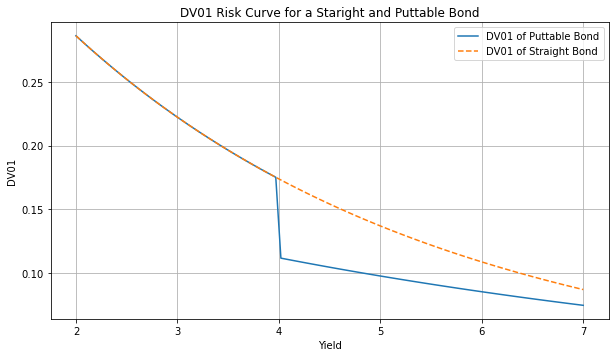

In [10]:
#fig = plt.figure();
plt.figure(figsize=(10, 12))
#
plt.subplot(2, 1, 1) 
#plt.figure(figsize=(10, 6))
plt.plot(yield_rates, Putable_bond_prices,label='Puttable Bond Prices')
plt.plot(yield_rates, bond_prices, '--', label='Straight Bond Prices')

plt.xlabel('Yield(%)')
plt.ylabel('Bond Prices')
plt.title('Straight and Puttable Bond Prices vs Yield')
plt.legend()
plt.grid(True)
plt.show();

plt.figure(figsize=(10, 12))
# Plot DV01 curve
plt.subplot(2, 1, 2) 
plt.plot(yield_rates, DV01_values_Putable_Bond,label='DV01 of Puttable Bond')
plt.plot(yield_rates, DV01_values_Straight_Bond,'--', label='DV01 of Straight Bond')
plt.xlabel('Yield')
plt.ylabel('DV01')
plt.title('DV01 Risk Curve for a Staright and Puttable Bond')
plt.legend()
plt.grid(True)
plt.show();

***STEP 5***
-------------

In [11]:
# Determine maximum exposure for Putable bond in comparison with
DV01_differences = [x1 - x2 for (x1, x2) in zip(DV01_values_Straight_Bond, DV01_values_Putable_Bond)]
max_exposure_rate = yield_rates[np.argmax(DV01_differences)]/100
#max_exposure_value = max(dv01_values)

print(f"Maximum DV01 exposure before {put_option_year} years (for Putable bond in comparison with Staright bond) is at yield: {max_exposure_rate:.2%}")
#print(f"Maximum DV01 value: {max_exposure_value:.2f}")

# Determine if bond should be sold at premium or discount
Mask = (bond_price(face_value, coupon_rate, put_option_year, interest_rate_curve(put_option_year) , n) -
        bond_price(face_value, coupon_rate, put_option_year, interest_rate_curve(maturity) , n)
       )
premium_discount_comparison = "premium" if Mask > 0 else "discount"
print(f"The puttable bond should be sold at a {premium_discount_comparison} compared to a bond without optionability.")


Maximum DV01 exposure before 15 years (for Putable bond in comparison with Staright bond) is at yield: 4.02%
The puttable bond should be sold at a premium compared to a bond without optionability.
